https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Statistical Programming with Python: Bike Sharing Prediction
**Group Assignment**  
By Team O2-2 (B)  
eddited by Duarte for Advanced Python Individual Assignment

Disclaimer: I had to performe some heavy transformation on the original model submitted to evaluation. Mostly it had to do with cleaning noise and make everything more smooth for the purpose of this assignment. Performance was not much affected and I kept all the main sections.

[1. Libraries](#1.-Libraries)  
[2. Load dataset](#2.-Load-dataset)  
[3. Dask basic config](#3.-Dask-basic-configuration)  
[4. Data preparation](#4.-Data-preparation)  
[5. Dask ML algos](#5.-Dask-Machine-Learning-algos)  
> [5.1 Linear regression](#5.1-Linear-regression)  
> [5.2 Random forest](#5.2-Random-forest)  
> [5.3 XGBoost](#5.3-XGBoost)  
> [5.4 Hyperparameter optimization](#5.4-Hyperparameter-optimization)  
> [5.5 Pipeline](#5.5-Pipeline)  

## 1. Libraries

In [1]:
# Base
import numpy as np
import pandas as pd 

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Ml algos
import xgboost
from sklearn.ensemble import RandomForestRegressor

# Evaluation
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# Dask base
import dask.dataframe as dd

# Dask preprocessing
from dask_ml.preprocessing import Categorizer, DummyEncoder

# Dask ml algos
from dask_ml.linear_model import LinearRegression
from dask_ml.xgboost import XGBRegressor
import dask_xgboost

# Dask pipeline
from sklearn.pipeline import make_pipeline

***
*In order to leverage on the cloud solutions existent, I'm reading the file directly from a private owned S3 container in AWS.*

## 2. Load dataset

In [2]:
ddf_org = dd.read_csv( # Loading into a dask dataframe
    'https://s3.eu-west-2.amazonaws.com/adv-py-assignment/hour.csv'
)

In [3]:
ddf = ddf_org # to avoid the need to load the data several times

***
## 3. Dask basic configuration

*To ensure the most efficient handling of data and modeling, I'm initializing the dask client in the beginning of the script.*

In [4]:
from dask.distributed import Client

# local connection to client
client = Client(n_workers=4, threads_per_worker=1)

# If using a cluster, we should instead use the following code:
# client = Client('ip:port')

***
## 4. Data preparation

*In data preparation I just did some simple data transformation like removing some columns and doing some basic transformation using specific dask_ml preprocessing algo.*

**Data visualization**  
In order to better gasp the information we have to modelling, we need to trace a correlations plot.
This is as well an opportunity to show that a dask dataframe can be ploted as easy as a pandas dataframe.

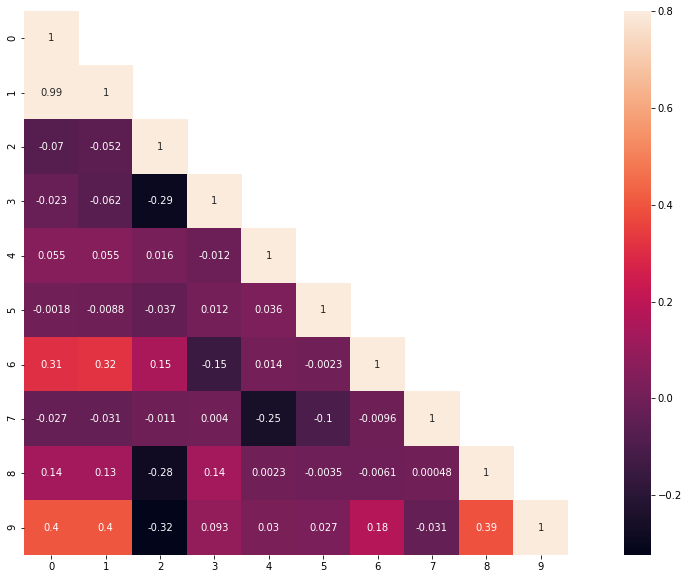

In [5]:
# Check the correlations of the different variables.
corrMatt = ddf[
    [
        "temp",
        "atemp",
        "hum",
        "windspeed",
        "workingday",
        "weekday",
        "season",
        "holiday",
        "hr",
        "cnt",
    ]
].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.heatmap(corrMatt, mask=mask, vmax=0.8, square=True, annot=True)

Visualizing the data will show important insights for the modelling phase.
First of all we will take a look at the variables that showed the highest correlation with the cnt values in the correlation matrix: temp and hum. Showing a clearly linear relation between these two variable and the count variable.

Looking at the distribution of the rentals on a daily basis there are clearly periods of higher demand during a day, ie the moments people have to get home from/ go to work/school, and the other moments of the day.
Of course there is a big seasonal effect as well as an effect of wheteher it is a working day or not.

**Removing columns**  
As we are predicting **<font color=blue>'cnt'</font>** we will take out some columns that show high correlation and would bring high bias to the modeling

In [6]:
# Predict cnt so casual and registered can be left out
ddf = ddf.drop(["casual", "registered"], axis=1)

In [7]:
# Remove atemp because of the almost 1 to 1 correlation with temp.
ddf = ddf.drop(["atemp", "dteday"], axis=1)

**Dummy encoding**  
Here we converted every column type that was an **<font color=grey>'object'</font>**, into categories in order to facilitate the dummy creation. In this particular case, this *"dummyfying"* does not produce any result because all the data is alread numeric.

In [8]:
cat = Categorizer()
ddf = cat.fit_transform(ddf)

In [9]:
dum = DummyEncoder()
ddf = dum.fit_transform(ddf)

In [10]:
# ddf.dtypes
# ddf_org.dtypes

**Train/test split**  
And finally we end up with a train/ test split for the modelling fase.
This split is based on the predicting goal - *predict **<font color=blue>'cnt'</font>** values for October onwards*

In [11]:
train = ddf[ddf["instant"]<15212]
test = ddf[ddf["instant"]>=15212]

Getting data ready for dask algos, we need to produce dask array to make it more compliant with the different algos put in practice.

In [12]:
x_train = train.drop(['instant', 'cnt'], axis=1).to_dask_array()
y_train = train['cnt'].to_dask_array()

x_test = test.drop(['instant', 'cnt'], axis=1).to_dask_array()
y_test = test['cnt'].to_dask_array()

Additionally, in order to facilitate the pipeline creation fase, we are gonna do a fork of the dataset at this moment.

In [13]:
x_train_pp = train.drop(['instant', 'cnt'], axis=1)
y_train_pp = train['cnt']

x_test_pp = test.drop(['instant', 'cnt'], axis=1)
y_test_pp = test['cnt']

***
## 5. Dask Machine Learning algos

### 5.1 Linear regression
**With dask ml models**

To use as a baseline, we are going to build a basic Linear Regression. For this linear regression we are using a ***dask_ml algo***.

In [14]:
dask_lr = LinearRegression()
dask_lr.fit(x_train, y_train) # fitting the model

LinearRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
         intercept_scaling=1.0, max_iter=100, multi_class='ovr', n_jobs=1,
         penalty='l2', random_state=None, solver='admm',
         solver_kwargs=None, tol=0.0001, verbose=0, warm_start=False)

In [15]:
y_lr = dask_lr.predict(x_test) # predicting the model

To calculate the r2 score we used a sklearn metric to show the smooth transition between dask and sklearn api.

In [16]:
r2_score(y_pred=y_lr.compute(), y_true=y_test.compute()) # we use .compute() to convert values from the dask array

0.2908189442085951

### 5.2 Random forest
**With dask api for sklearn - joblib parallel backend**

Joblib is used as an api interface for sklearn from dask. This allows to run sklearn models with a dask dataframe and distributed processing. If we wanted to scale this model, it would be easier because of the use of this api.

In [17]:
from joblib import Parallel, parallel_backend

In [18]:
with parallel_backend("dask"): # everything that runs inside this model will be used in dask parallel processing
    rf_model = RandomForestRegressor(n_estimators=200)
    rf_model.fit(x_train, y_train)
    y_rf = rf_model.predict(x_test)

In [19]:
r2_score(y_pred=y_rf, y_true=y_test.compute()) # we use .compute() to convert values from the dask array

0.8729058720282804

### 5.3 XGBoost
**With dask ml models**

XGBoost is probably the model with higher potential from a dask integration. Using a native dask ml algo I implemented the xgboost model with considerably higher performance when comparing with the normal sklearn algo.

In [20]:
params = {"max_depth": 5, "alpha": 10, "n_estimators": 5000, "colsample_bytree": 0.3}

xgb_model = dask_xgboost.train(
    client=client, data=x_train, labels=y_train, num_boost_round=10, params=params
)

In [21]:
y_xgb = dask_xgboost.predict(client, xgb_model, x_test).persist()

In [22]:
r2_score(y_pred=y_xgb.compute(), y_true=y_test.compute())

0.46743490326724746

### 5.4 Hyperparameter optimization
**Optimizing the best model - random forest**

We use a native dask algo to optimize the best model, in this case random forest.

In [23]:
from dask_searchcv import GridSearchCV

params = [
    {
        "n_estimators": [100, 150, 200, 250, 300],
        "max_features": ["auto", "sqrt", "log2"],
    }
]

search = GridSearchCV(rf_model, params, cv=3)
search.fit(x_train, y_train)

best_grid = search.best_estimator_
y_rf_o = best_grid.predict(x_test)

r2_score(y_pred=y_rf_o, y_true=y_test.compute())

0.8714331876960065

### 5.5 Pipeline
**Wrapping everything in a pipeline**

I implemented a pipeline to show how it could work with dask algos. In this pipeline i included some preprocessing transformations as well as the best model I encounter.

In [24]:
pipe = make_pipeline(
    Categorizer(),
    DummyEncoder(),
    RandomForestRegressor(n_estimators=200))

y_rf_pipe = pipe.fit(x_train_pp, y_train_pp).predict(x_test_pp)

r2_score(y_pred=y_rf_pipe, y_true=y_test.compute())

0.8736581207677899

In [25]:
client.close()